In [3]:
import torch
import torchaudio
import polars
import matplotlib.pyplot as plt

import helpers.input_processor as ip


In [4]:
data_dir = "data/raw_training/training_data/"
df = ip.ingest_data(data_dir)

Reading from .txt files in data/raw_training/training_data/: 100%|██████████| 942/942 [00:12<00:00, 76.19it/s] 


In [5]:
# output metadata of first audio file
metadata = torchaudio.info(data_dir + df['audio_file'][0][0])
print(metadata)

AudioMetaData(sample_rate=4000, num_frames=41152, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [6]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        
    figure.suptitle('Waveform')
    plt.show(block=False)


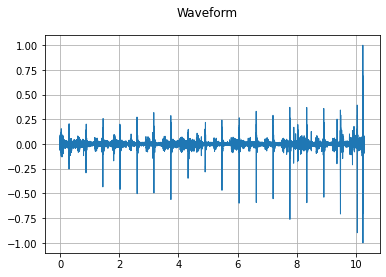

In [7]:
waveform = torchaudio.load(data_dir + df['audio_file'][0][0])[0]
plot_waveform(waveform, 4000)

In [8]:
def plot_spectrogram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    fig, axes = plt.subplots(num_channels, 1)
    for c in range(num_channels):
        axes.specgram(waveform[c], Fs=sample_rate)
    fig.suptitle(title)
    plt.show(block=False)

In [59]:
def create_spectrogram(waveform, sample_rate):
    spectrogram = torchaudio.transforms.Spectrogram()(waveform)
    return spectrogram

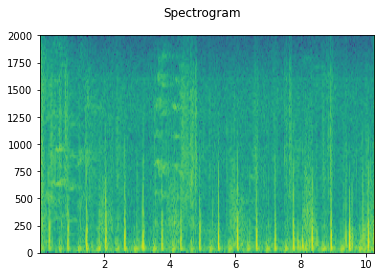

In [10]:
plot_spectrogram(waveform, 4000)

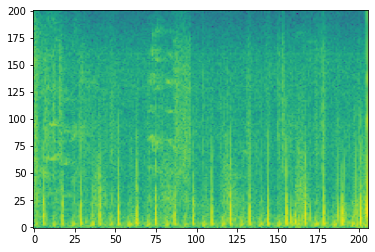

In [60]:
specgram = create_spectrogram(waveform, 4000)
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), aspect='auto', origin='lower')


In [125]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class AudioDataset(Dataset):
    def __init__(self, audioPaths, labels):
        self.audioPaths = audioPaths
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        waveform = torchaudio.load(self.audioPaths[idx])[0]
        spectrogram = torchaudio.transforms.Spectrogram()(waveform)
        spectrogram = spectrogram / spectrogram.abs().max()
        return spectrogram, self.labels[idx]



## Put the files into a tensor and generate labels for them

In [126]:
# loop through the dataset and create a list of audio paths
audioPaths = []
labels = []
for i in range(len(df)):
    for j in range(len(df['audio_file'][i])):
        audioPaths.append(data_dir + df['audio_file'][i][j])
        # check if there is a murmur at the recording location
        murmur = False
        for k in df['murmur_locations'][i]:
            if k in df['audio_file'][i][j]:
                labels.append(1)
                murmur = True
                break
        if murmur == False:
            labels.append(0)



print("Audio path number: ", len(audioPaths))
print("Label number: ", len(labels))

Audio path number:  3163
Label number:  3163


### Add lists into dataset

In [127]:
dataset = AudioDataset(audioPaths, labels)

In [128]:
# simple performance test
import time
start = time.time()
dataset[0]
end = time.time()

speed = (end - start)
print("Speed: ", speed * 1000, "ms")

Speed:  1.4994144439697266 ms
